<a href="https://colab.research.google.com/github/Kath2011/TFE/blob/main/TFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VALIDACIÓN CRUZADA (5-fold) – RANDOM FOREST
{'accuracy': np.float64(0.9994001468466902), 'precision': np.float64(0.9996130728403679), 'recall': np.float64(0.9992377955923623), 'f1': np.float64(0.9994253928875775)}
VALIDACIÓN CRUZADA (5-fold) – GRADIENT BOOSTING
{'accuracy': np.float64(0.9990942815208392), 'precision': np.float64(0.9994479256456469), 'recall': np.float64(0.9988168771122103), 'f1': np.float64(0.9991322889980825)}


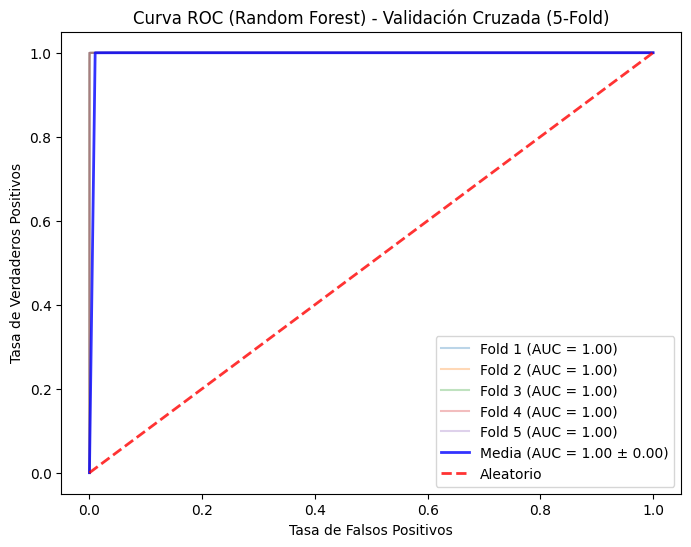

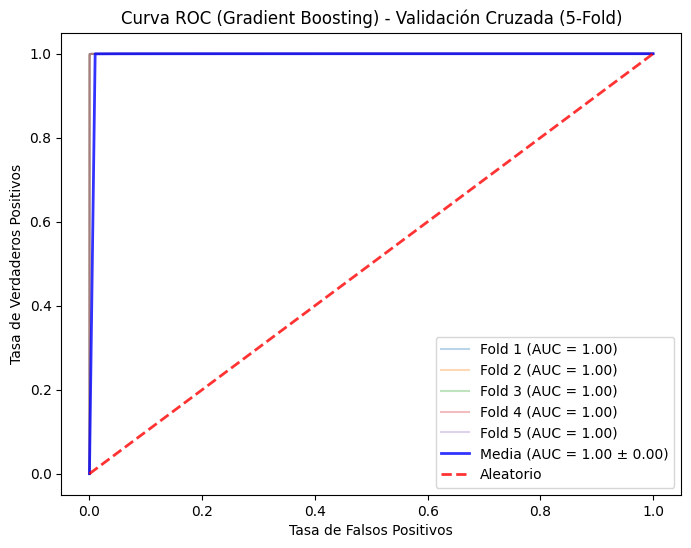

 COMPARACIÓN FINAL DE MÉTRICAS:
                   accuracy  precision    recall        f1
Random Forest      0.999400   0.999613  0.999238  0.999425
Gradient Boosting  0.999094   0.999448  0.998817  0.999132


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,
f1_score, make_scorer)


import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
df = pd.read_csv("StealthPhisher2025.csv")  # , nrows=10000 solo las primeras 10.000 filas
columnas_a_eliminar = ["URL", "Domain", "URLComplexity", "TLD", "KolmogorovComplexity",
                       "ShannonEntropy", "FractalDimension",  #eliminación de columnas individuales
                       ]

df = df.drop(columns=columnas_a_eliminar)

# Codificar variables categóricas si existen
label_encoder = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_encoder.fit_transform(df[col])

# Eliminar valores nulos
df = df.dropna()

#print(df.head())

#separar caracteristicas x y etiqueta y
x= df.drop("Label", axis=1)
y= df["Label"]

#Division inicial para evaluacion no cruzada
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Paso 3: Entrenar modelos en datos divididos
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

rf.fit(x_train, y_train)
gb.fit(x_train, y_train)
rf_preds = rf.predict(x_test)
gb_preds = gb.predict(x_test)

#Paso 4: Evaluación puntual (no cruzada)
#print("EVALUACIÓN SIMPLE – RANDOM FOREST")
#print(confusion_matrix(y_test, rf_preds))
#print(classification_report(y_test, rf_preds, digits=4))

#print("EVALUACIÓN SIMPLE – GRADIENT BOOSTING")
#print(confusion_matrix(y_test, gb_preds,))
#print(classification_report(y_test, gb_preds, digits=4))

#Paso 5: Evaluación con VALIDACIÓN CRUZADA
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

rf_cv = cross_validate(rf, x, y, cv=5, scoring=scoring)
gb_cv = cross_validate(gb, x, y, cv=5, scoring=scoring)

def resumen(scores_dict):
    return {k.replace('test_', ''): np.mean(v) for k, v in scores_dict.items() if k.startswith('test_')}

print("VALIDACIÓN CRUZADA (5-fold) – RANDOM FOREST")
print(resumen(rf_cv))

print("VALIDACIÓN CRUZADA (5-fold) – GRADIENT BOOSTING")
print(resumen(gb_cv))

# [Todo el código anterior de preprocesamiento se mantiene igual hasta...]

# Paso 6: Evaluación con VALIDACIÓN CRUZADA y Curvas ROC
from sklearn.model_selection import StratifiedKFold

# Configuración de K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Función para plotear ROC con CV
def plot_cv_roc(model, X, y, cv, model_name):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(8, 6))

    for i, (train, test) in enumerate(cv.split(X, y)):
        model.fit(X.iloc[train], y.iloc[train])
        y_proba = model.predict_proba(X.iloc[test])[:, 1]

        # Calcular curva ROC
        fpr, tpr, _ = roc_curve(y.iloc[test], y_proba)
        roc_auc = roc_auc_score(y.iloc[test], y_proba)

        # Interpolar para promediar
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        # Plotear cada fold (opcional)
        ax.plot(fpr, tpr, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

    # Plotear la media y desviación estándar
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr, color='b',
            label=f'Media (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
            lw=2, alpha=.8)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Aleatorio', alpha=.8)

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f'Curva ROC ({model_name}) - Validación Cruzada (5-Fold)')
    ax.legend(loc="lower right")
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.show()

# Generar curvas ROC con CV
plot_cv_roc(rf, x, y, cv, "Random Forest")
plot_cv_roc(gb, x, y, cv, "Gradient Boosting")


#Paso 7: Comparación en tabla final
rf_metrics = resumen(rf_cv)
gb_metrics = resumen(gb_cv)

comparacion = pd.DataFrame([rf_metrics, gb_metrics], index=["Random Forest", "Gradient Boosting"])
print(" COMPARACIÓN FINAL DE MÉTRICAS:")
print(comparacion)


